In [7]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import itertools
import pickle
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess

from src.features import build_features
from src.models import train_model

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [9]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

In [10]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# 1. Proyección de Egresos Hospitalarios para Diagnósticos más frecuentes en el INT

En este cuadernillo se quiere crear un modelo para estimar la proyección de egresos
hospitalarios para los diagnósticos más relevantes para el INT hasta el año 2035. Para realizar
la proyección se utilizará el modelo Prophet, y se hará una proyección por día.

Para este análisis se obviará el año 2019 para entrenar/testear el modelo. Esto, ya que es un
año anómalo.


In [179]:
df = egresos_torax.query("ANO_EGRESO <= 2019")
df = df[df["DIAG1"].isin(DIAGS_RELEVANTES)]
df = df.drop(
    columns={
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    }
)

TARGET = "n_egresos"
# Agrupa por día y genera un calendario completo hasta el 2019 (imputa días faltantes)
df = df.groupby("FECHA_EGRESO").sum().resample("D").sum()
df = df.drop(columns="DIAG1")[[TARGET]]

## 1.1 Separación de muestra y Modelamiento


In [180]:
CORTE_VALID = "2019-01-01"

train = df[df.index < CORTE_VALID]
valid = df[df.index >= CORTE_VALID]

# 2. Modelo Híbrido


## 2.1 Preprocesamiento Modelo Híbrido


In [196]:
# Train Set (To use for cross-validation and hyperparameter tuning)
train_hibrido = train[[TARGET]]

X_train_1 = DeterministicProcess(index=train_hibrido.index, order=1, drop=True).in_sample()
X_train_2 = build_features.create_features_datetime_index(train_hibrido)
X_train_2 = build_features.create_lag_features(X_train_2, TARGET, [1, 7, 14, 30, 365], 0).drop(
    columns=TARGET
)

y_train = train_hibrido[TARGET]

# Validation Set
valid_hibrido = valid[[TARGET]]
ULTIMO_TREND_TRAIN = X_train_1.iloc[-1, 0]

X_valid_1 = (
    DeterministicProcess(index=valid_hibrido.index, order=1, drop=True).in_sample()
    + ULTIMO_TREND_TRAIN
)
X_valid_2 = build_features.create_features_datetime_index(valid_hibrido)
X_valid_2 = build_features.create_lag_features(X_valid_2, TARGET, [1, 7, 14, 30, 365], 0).drop(
    columns=TARGET
)
y_valid = valid_hibrido[TARGET]

## 2.2 Entrenamiento del Modelo Hibrido


In [197]:
# Define models

modelo_1 = LinearRegression()
modelo_2 = XGBRegressor()


# Create the hyperparameter grids for each model
param_grid_1 = {"fit_intercept": [True, False]}

param_grid_2 = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

# Example usage
# Assuming modelo_1 and modelo_2 are instances of scikit-learn models

# Create the hybrid model
hybrid_model = train_model.ModeloHibrido(modelo_1, modelo_2, param_grid_1, param_grid_2, n_splits=5)

# Fit the model
hybrid_model.fit_with_hyperparameter_tuning(X_train_1, X_train_2, y_train)
hybrid_model.check_validation_score(X_valid_1, X_valid_2, y_valid)

Tuning modelo_1...
Best hyperparameters for modelo_1: {'fit_intercept': True}
CV Results for modelo_1:
  MAE Mean Train Score: -1.4717373318249
  MAE Mean Test Score: -2.156128317375251

Tuning modelo_2...
Best hyperparameters for modelo_2: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
CV Results for modelo_2:
  MAE Mean Train Score: -0.8899699745308841
  MAE Mean Test Score: -1.6526965753489193

Training process completed.
Performance on Validation Set:
  MAE: 1.8475036498092123
  MAPE: 47.31808112513693



In [198]:
valid_hibrido["yhat"] = hybrid_model.predict(X_valid_1, X_valid_2)

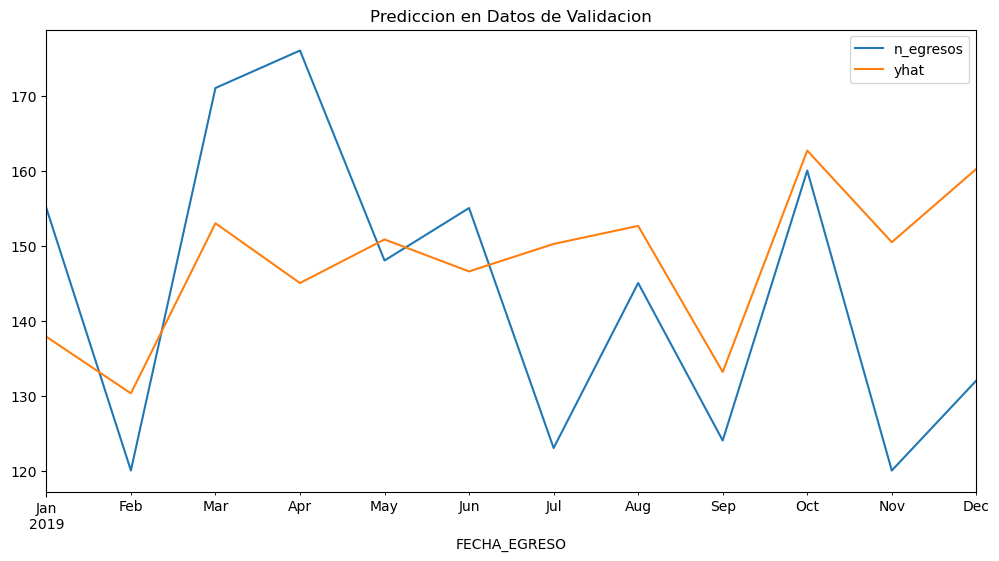

In [205]:
valid_hibrido.resample("M").sum().plot(title="Prediccion en Datos de Validacion")
plt.show()

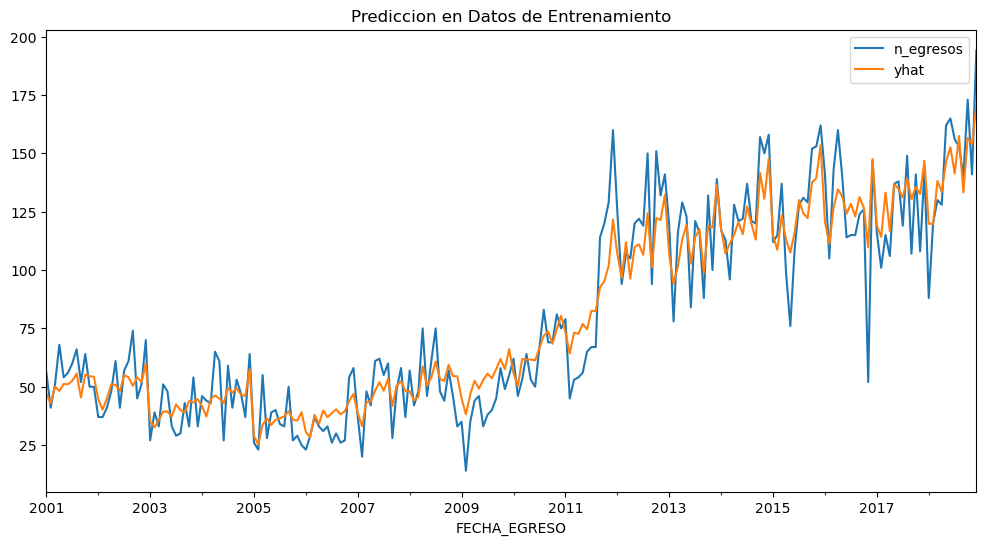

In [206]:
train_hibrido["yhat"] = hybrid_model.predict(X_train_1, X_train_2)
train_hibrido.resample("M").sum().plot(title="Prediccion en Datos de Entrenamiento")
plt.show()

## Reentrenar con todos los datos

Una vez encontrado todos los mejores hiperparametros, se procedera a reentrenar un modelo con todos
los datos y con los mejores hiperparametros.

In [208]:
# Define models

modelo_1 = LinearRegression(fit_intercept=True)
modelo_2 = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)

# Example usage
# Assuming modelo_1 and modelo_2 are instances of scikit-learn models

# Create the hybrid model
hybrid_model = train_model.ModeloHibrido(modelo_1, modelo_2, None, None, None)


# Realizar preprocesamiento con todos los datos
TARGET = "n_egresos"

X_all_1 = DeterministicProcess(index=df.index, order=1, drop=True).in_sample()
X_all_2 = build_features.create_features_datetime_index(df)
X_all_2 = build_features.create_lag_features(X_all_2, TARGET, [1, 7, 14, 30, 365], 0).drop(
    columns=TARGET
)
y_all = df[TARGET]

# Fit the model
hybrid_model.fit(X_all_1, X_all_2, y_all)

In [125]:
with open("../models/hybrid_model.pickle", "wb") as file:
    pickle.dump(hybrid_model, file)

## Predicción del Futuro con modelo Hibrido


In [209]:
futuro = pd.DataFrame(index=pd.date_range("2020-01-01", "2035-12-31"))

In [210]:
ULTIMO_TREND_VALID = X_valid_1.iloc[-1, 0]

X_futuro_1 = (
    DeterministicProcess(index=futuro.index, order=1, drop=True).in_sample() + ULTIMO_TREND_VALID
)
X_futuro_2 = build_features.create_features_datetime_index(futuro)

In [211]:
futuro["prediccion"] = hybrid_model.predict(X_futuro_1, X_futuro_2)

ValueError: Feature shape mismatch, expected: 13, got 8

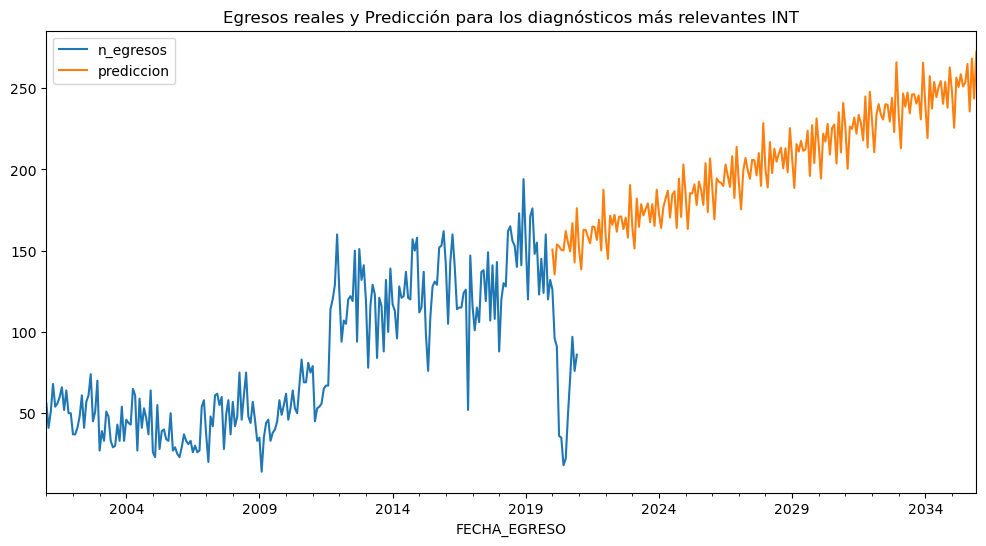

In [190]:
fig, axis = plt.subplots()

egresos_reales_diags_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_RELEVANTES)]
    .groupby("FECHA_EGRESO")
    .sum()
    .resample("M")[["n_egresos"]]
    .sum()
)

egresos_reales_diags_relevantes.plot(label="Egresos Reales", ax=axis)
futuro.resample("M").sum().plot(label="Predicción", ax=axis)
plt.legend()
plt.title("Egresos reales y Predicción para los diagnósticos más relevantes INT")
plt.show()

In [191]:
resumen_egresos_futuros = futuro.resample("Y").sum()
resumen_egresos_reales = egresos_reales_diags_relevantes.resample("Y").sum()

ultimo_valor_real_egresos_2019 = resumen_egresos_reales.iloc[-2, 0]
ultimo_valor_prediccion_egresos_2035 = resumen_egresos_futuros.iloc[-1, 0]

crecimiento_a_tener = (
    (ultimo_valor_prediccion_egresos_2035 / ultimo_valor_real_egresos_2019) - 1
) * 100

print(
    f"Tomando en cuenta la predicción de egresos de diagnósticos más relevantes, el hospital "
    f"debería crecer un {crecimiento_a_tener:.2f}% (de {ultimo_valor_real_egresos_2019} a "
    f"{ultimo_valor_prediccion_egresos_2035:.0f} egresos por año)"
)

Tomando en cuenta la predicción de egresos de diagnósticos más relevantes, el hospital debería crecer un 75.15% (de 1729 a 3028 egresos por año)


In [192]:
with pd.ExcelWriter("../data/interim/resumen_prediccion_futura.xlsx") as writer:
    resumen_egresos_futuros.to_excel(writer, sheet_name="egresos_predichos")
    resumen_egresos_reales.to_excel(writer, sheet_name="egresos_reales")

# 2. Predicción de Egresos por cada Diagnóstico separado

Una vez realizado el modelo predictivo para todos los diagnósticos agrupados, es necesario
saber el crecimiento de cada uno de los diagnósticos por separado. Es esperable que el aumento,
sumado de todos los diagnósticos de el crecimiento global de 77.90%. Sin embargo, es importante conocer la distribución de crecimientos. Por ejemplo:

- C341: Crecimiento del 230%
- I051: Crecimiento del -74.2%

Al realizar el promedio de estos dos diagnósticos debe dar el crecimiento global calculado.


In [171]:
df = egresos_torax.query("ANO_EGRESO <= 2019")
df = df[df["DIAG1"].isin(DIAGS_RELEVANTES)]
df = df.drop(
    columns={
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    }
)
df = df.groupby(["FECHA_EGRESO", "DIAG1"]).sum().reset_index(level=1)

> I495
Performance on Validation Set:
  MAE: 3.483728027504727
  MAPE: 43.77435043597429



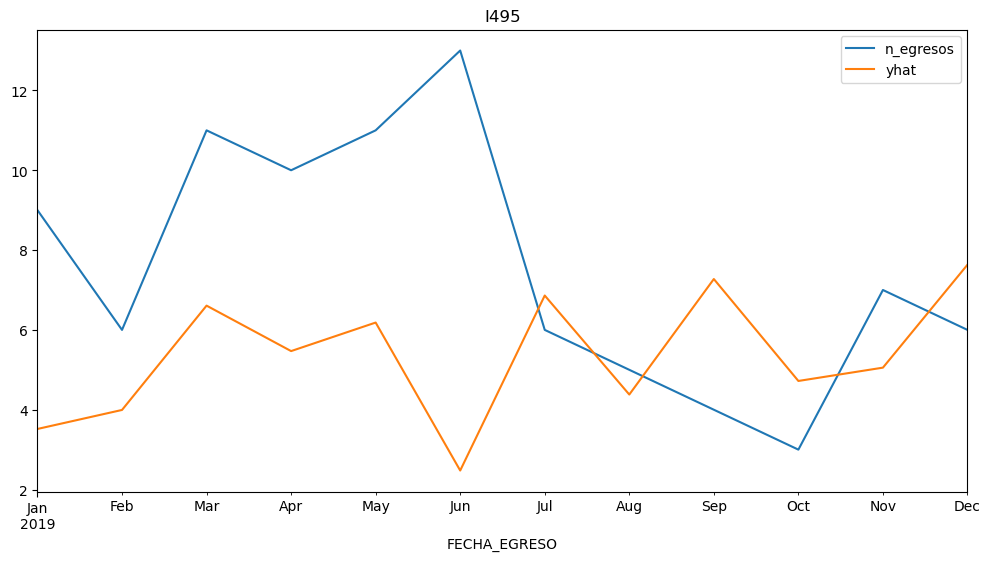

> J869
Performance on Validation Set:
  MAE: 1.415840160586499
  MAPE: 90.41299789347278



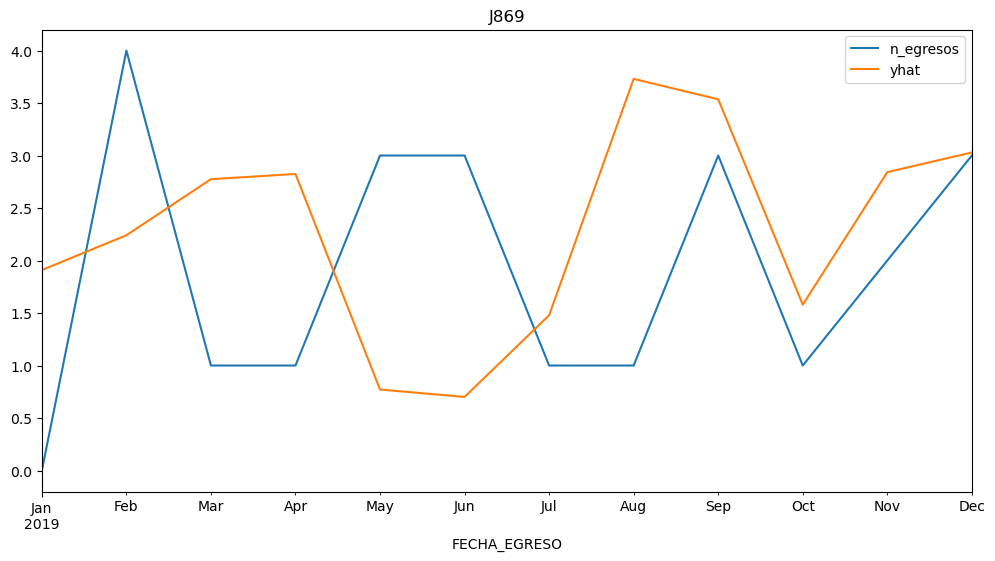

> D381
Performance on Validation Set:
  MAE: 4.216168195048733
  MAPE: 47.603266473372514



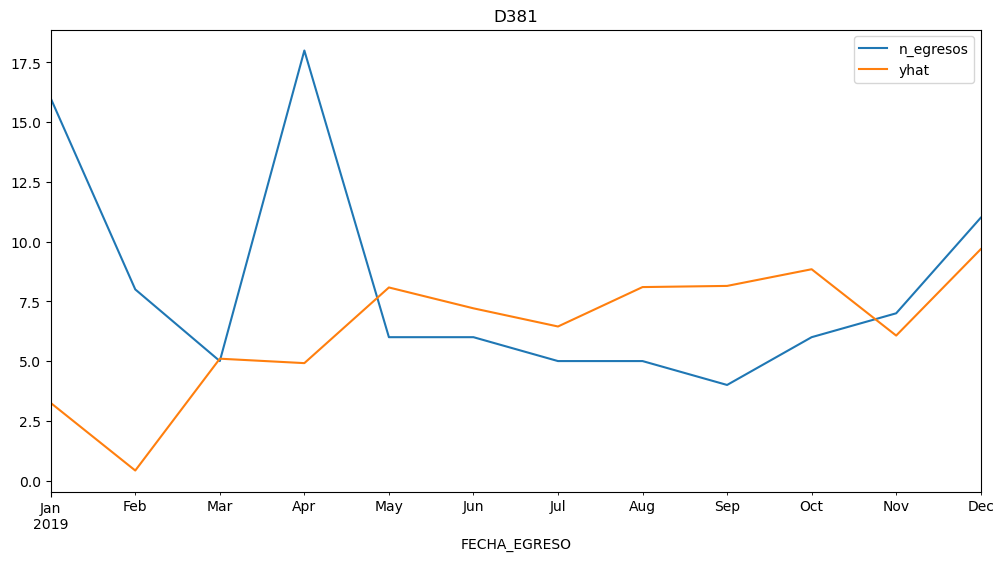

> J841
Performance on Validation Set:
  MAE: 2.7011242036475145
  MAPE: 47.081895509512144



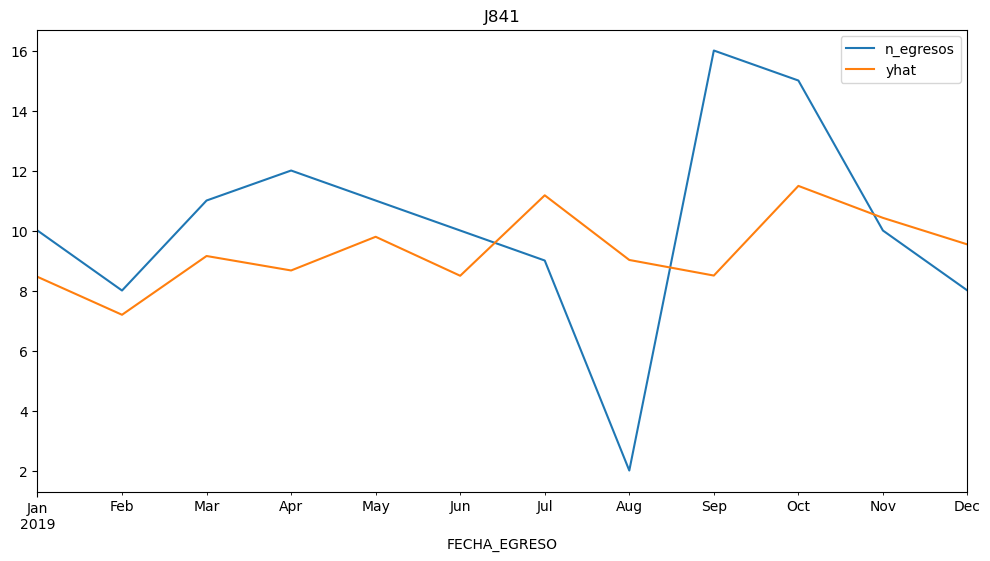

> C780
Performance on Validation Set:
  MAE: 1.354991897397299
  MAPE: 41.70984086745712



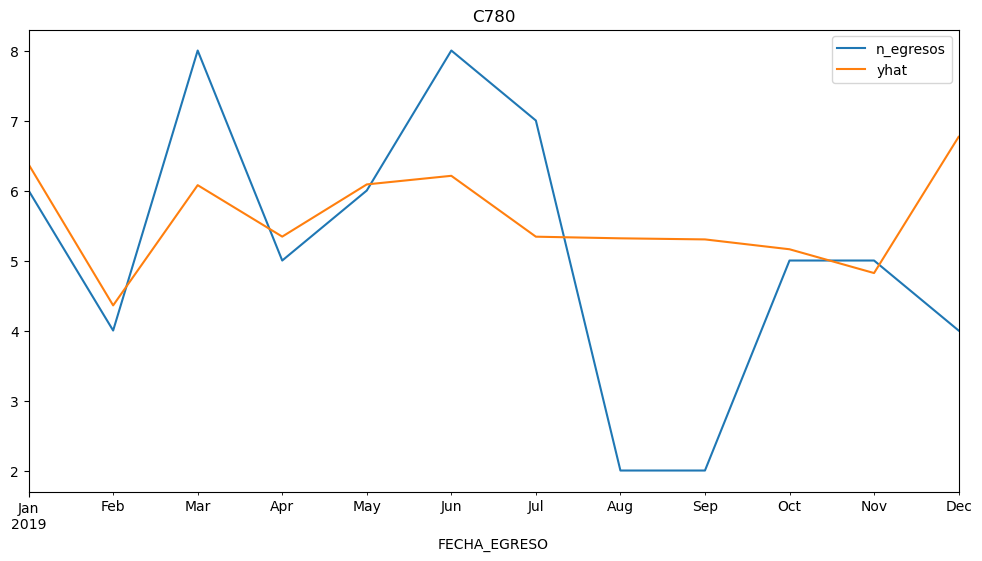

> I351
Performance on Validation Set:
  MAE: 1.9592034781179812
  MAPE: 60.7747907032823



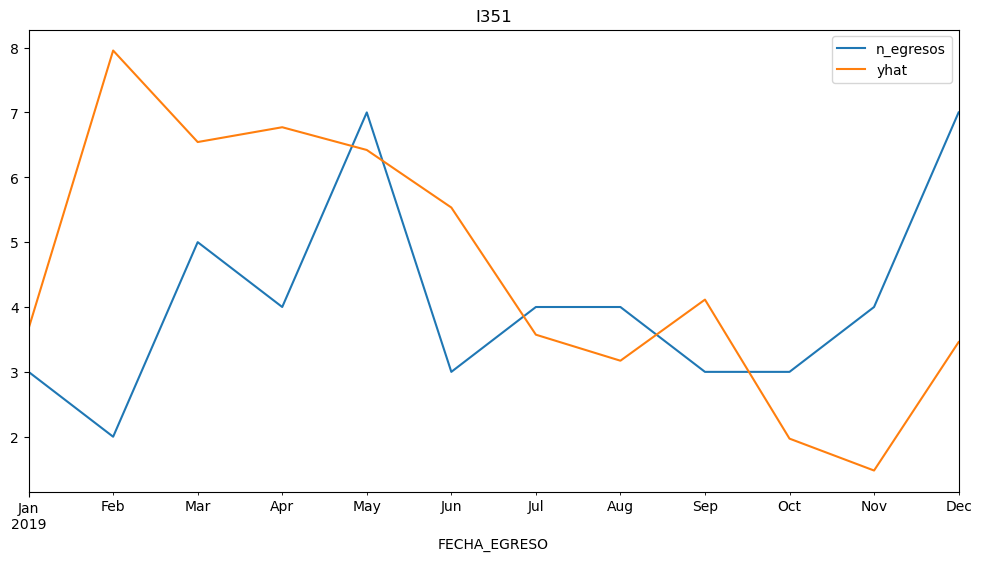

> J47X
Performance on Validation Set:
  MAE: 2.671623954146756
  MAPE: 126.5084770253276



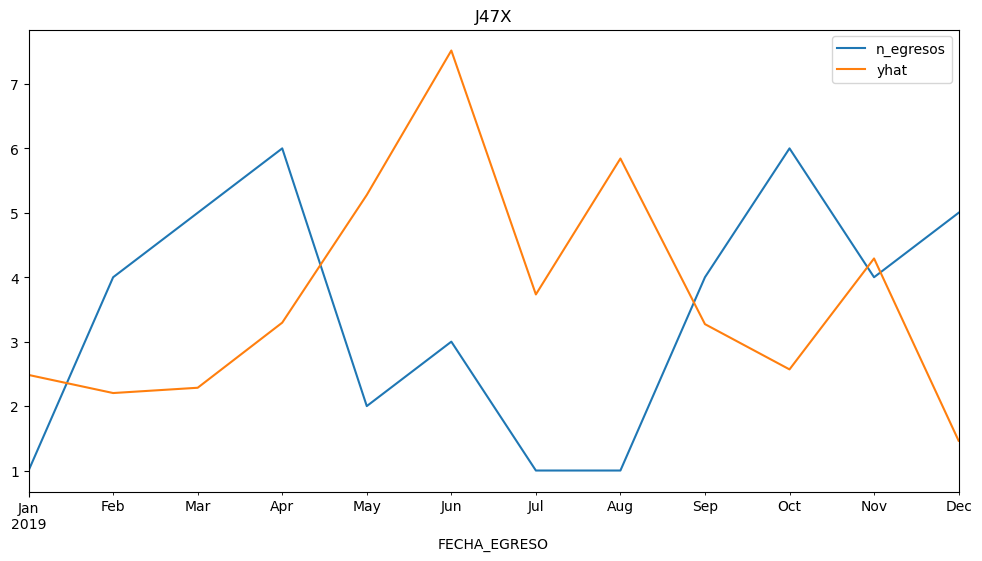

> J955
Performance on Validation Set:
  MAE: 1.7855461447882852
  MAPE: 58.001881778715095



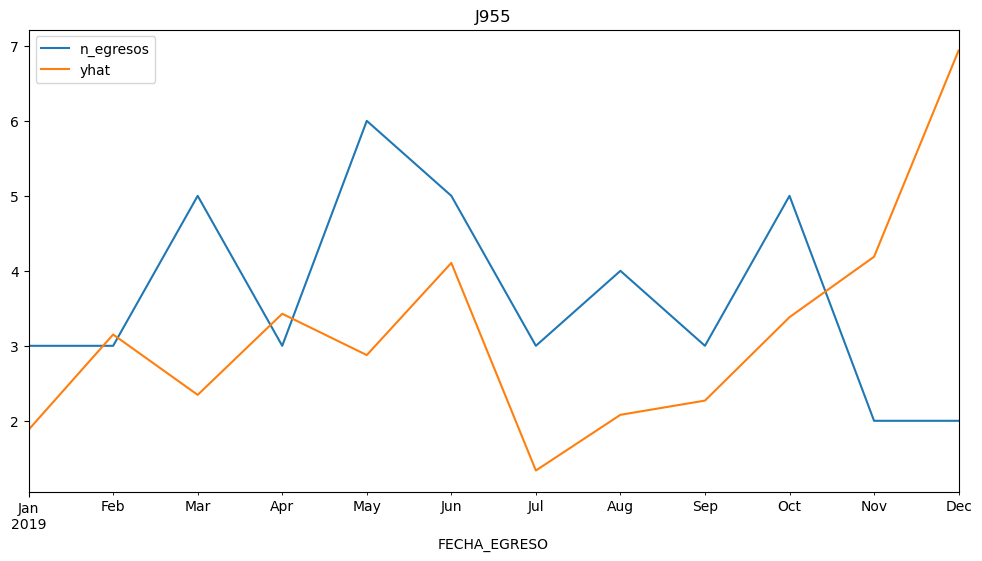

> C384
Performance on Validation Set:
  MAE: 0.6359746743625475
  MAPE: 36.589063319068785



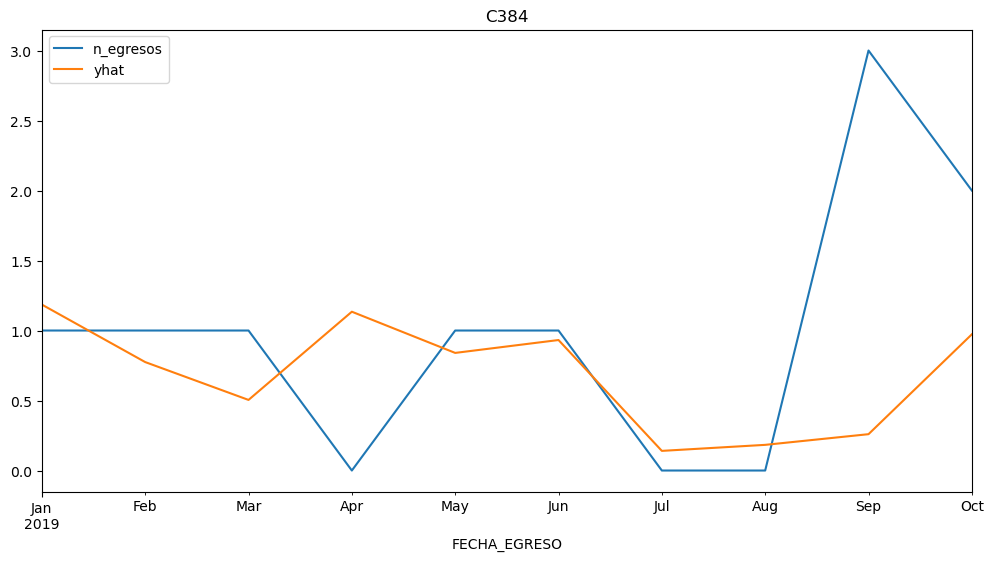

> C782
Performance on Validation Set:
  MAE: 2.6553559182194584
  MAPE: 151.9498974810603



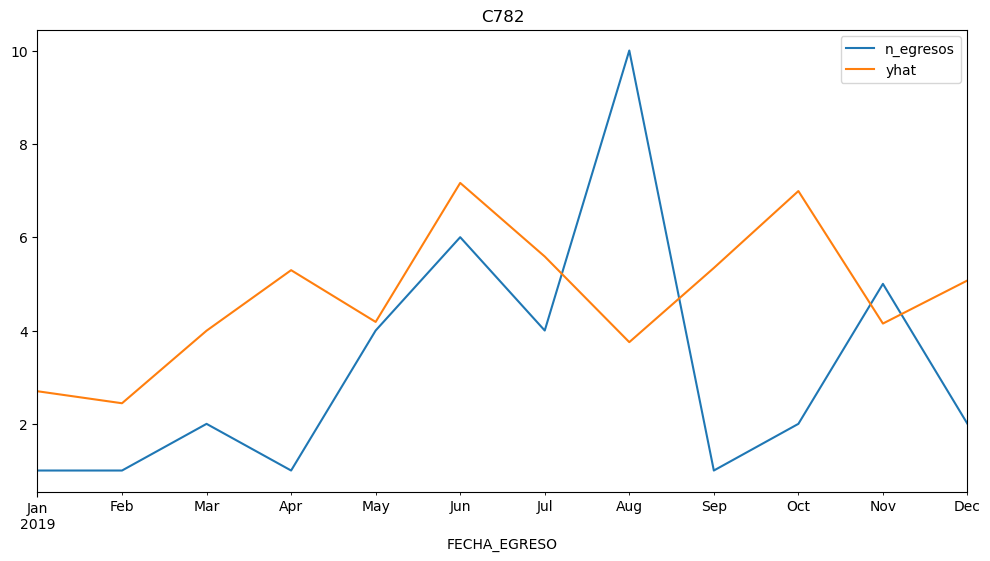

> I340
Performance on Validation Set:
  MAE: 1.7675166695032702
  MAPE: 93.70955026185072



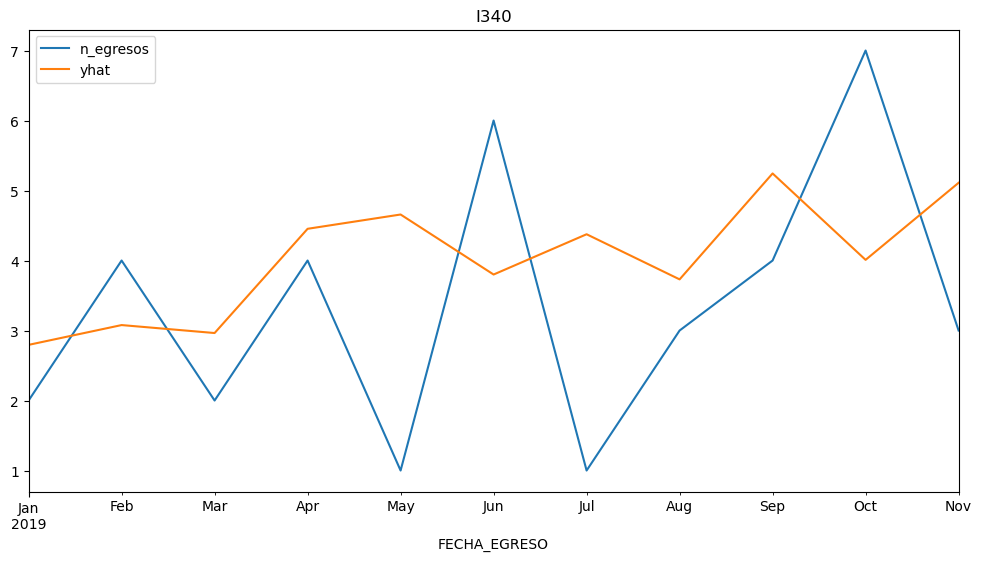

> J860
Performance on Validation Set:
  MAE: 5.021348260048366
  MAPE: 169.9340654774287



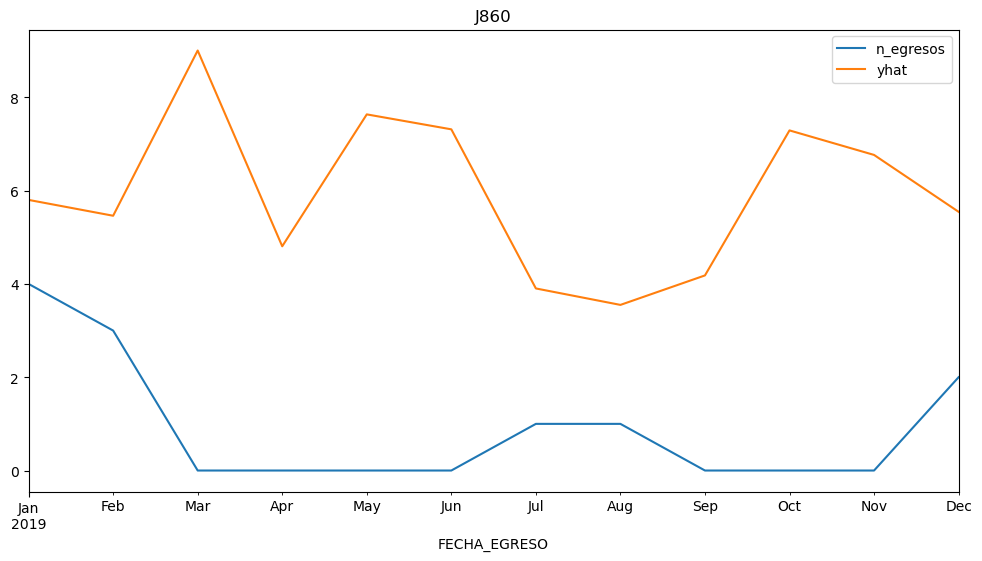

> I420
Performance on Validation Set:
  MAE: 1.4326673693239096
  MAPE: 63.393698660380174



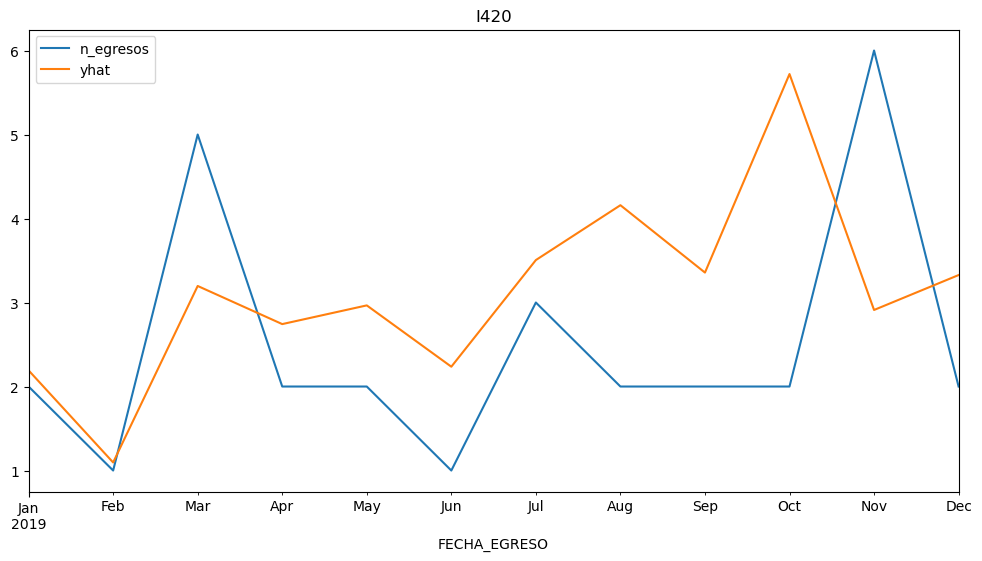

> T820
Performance on Validation Set:
  MAE: 1.3680965037450523
  MAPE: 52.696539537325094



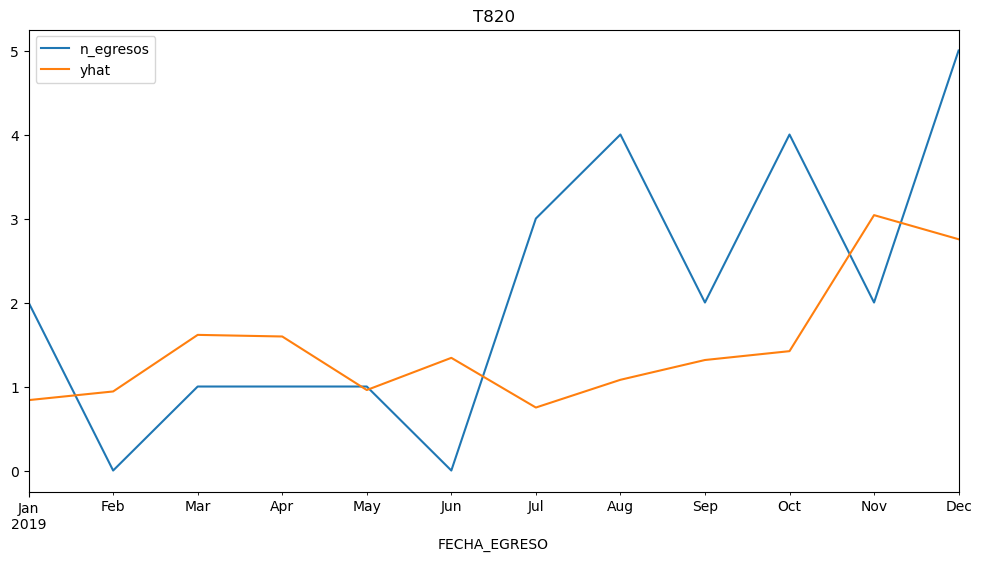

> C340
Performance on Validation Set:
  MAE: 1.368291611192008
  MAPE: 49.169899598907506



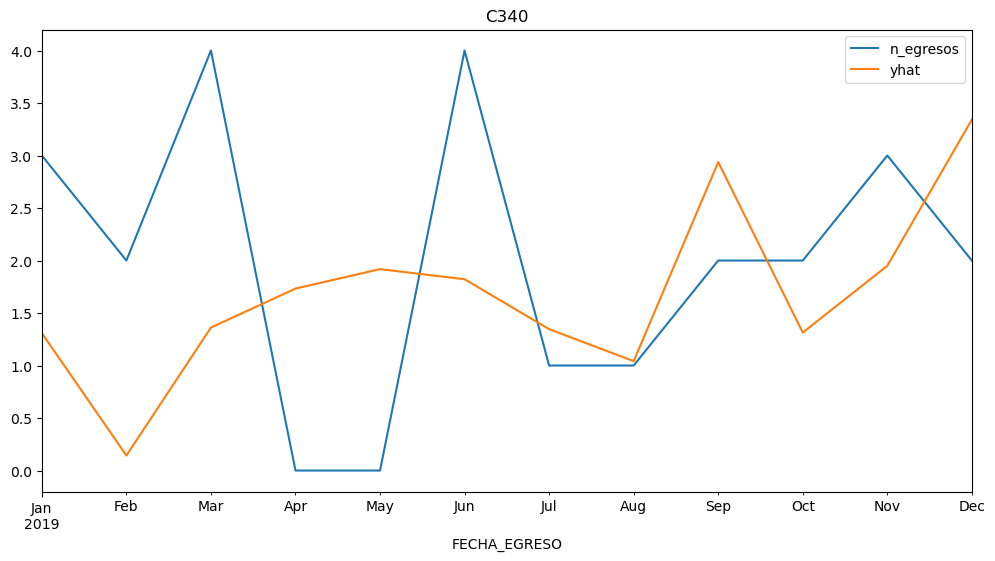

> C341
Performance on Validation Set:
  MAE: 4.243952434883326
  MAPE: 25.12543963585596



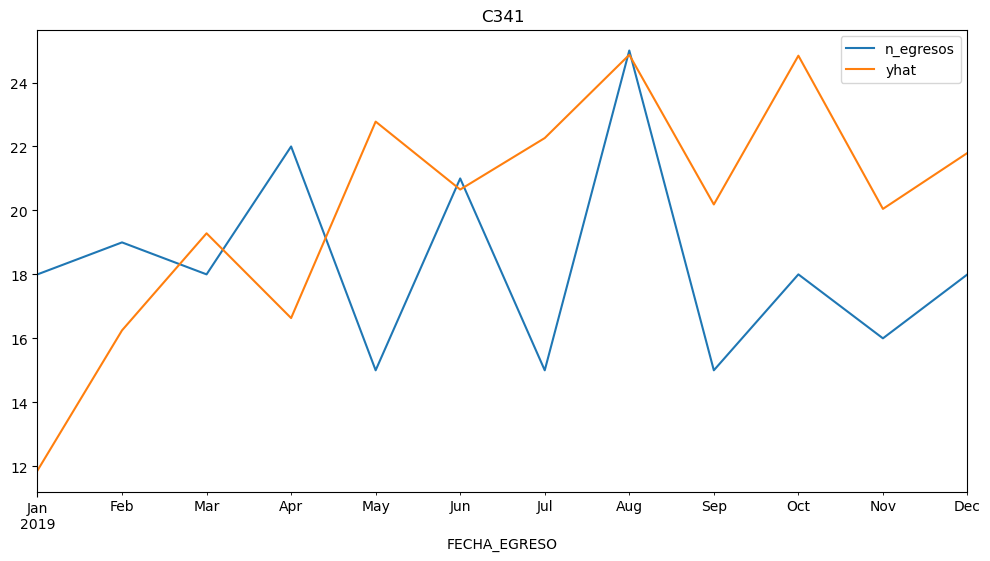

> C450
Performance on Validation Set:
  MAE: 1.9632444040610688
  MAPE: 172.15299162269093



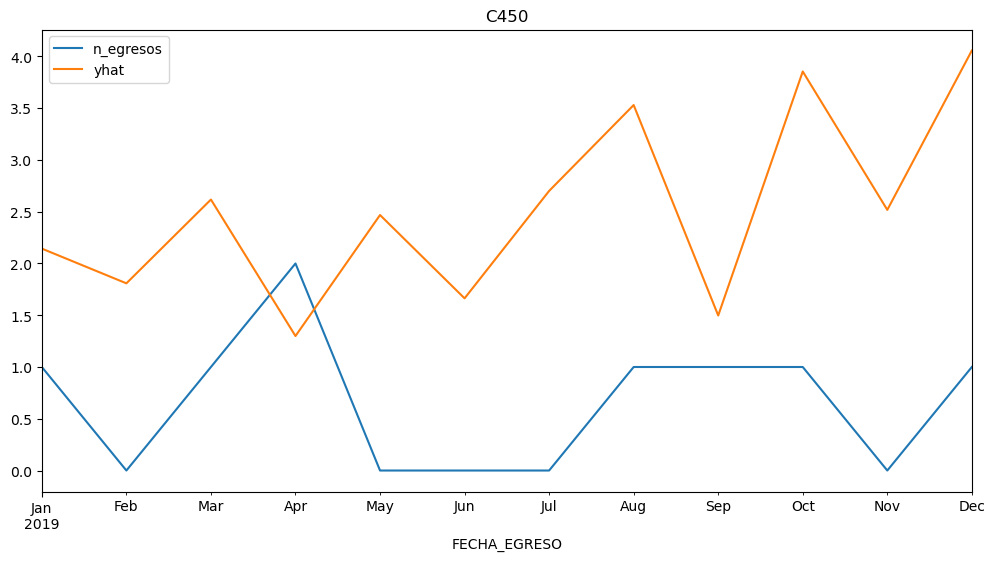

> T821
Performance on Validation Set:
  MAE: 2.225107153080128
  MAPE: 98.66641239341708



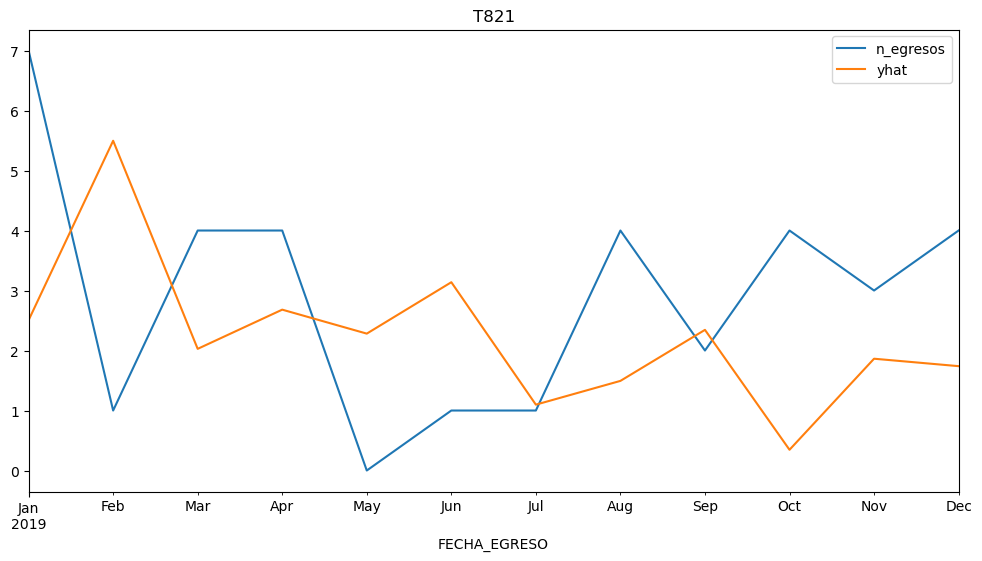

> C33X
Performance on Validation Set:
  MAE: 0.39630403963930727
  MAPE: 86.31706293060577



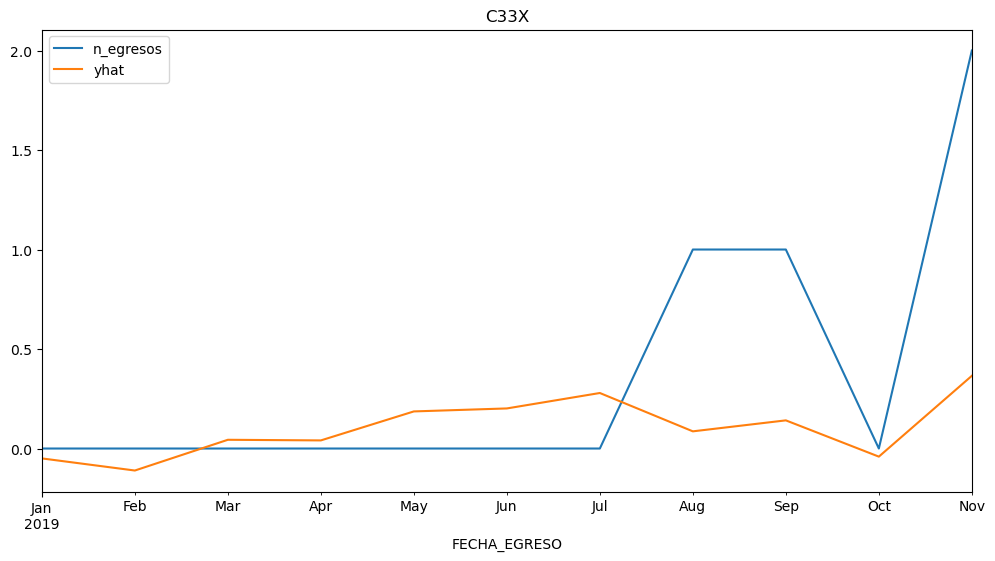

> C343
Performance on Validation Set:
  MAE: 3.8778421202688556
  MAPE: 51.279517500827254



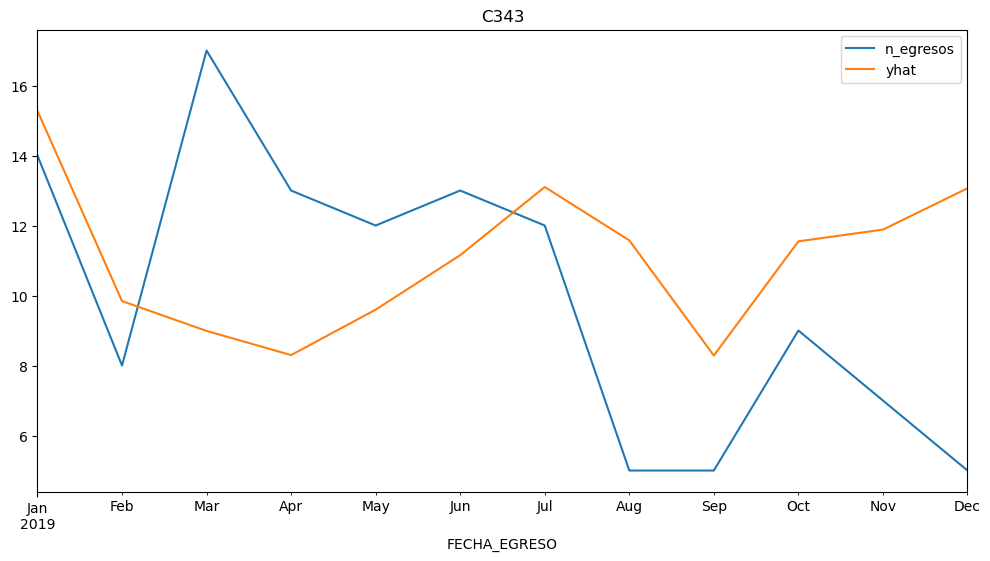

> I456
Performance on Validation Set:
  MAE: 1.2330420235410646
  MAPE: 42.67598895314854



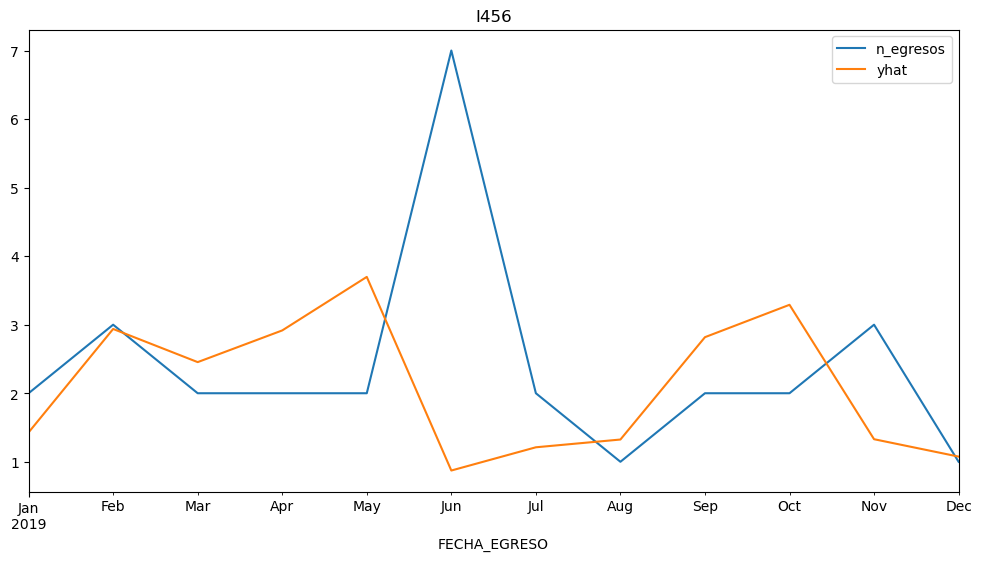

> I710
Performance on Validation Set:
  MAE: 1.4856860129490983
  MAPE: 58.5192396246502



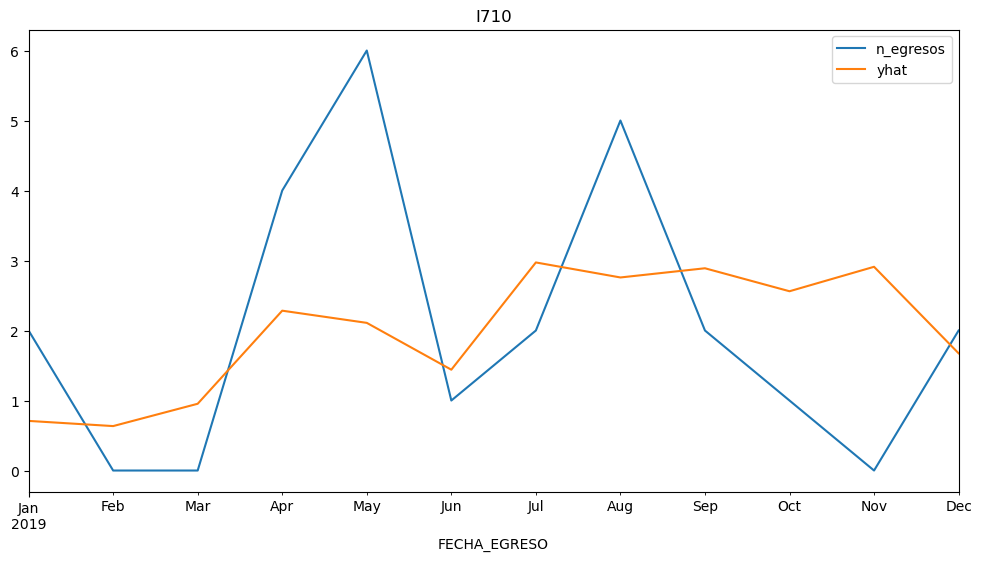

> J848
Performance on Validation Set:
  MAE: 2.633396705599202
  MAPE: 124.82098122135224



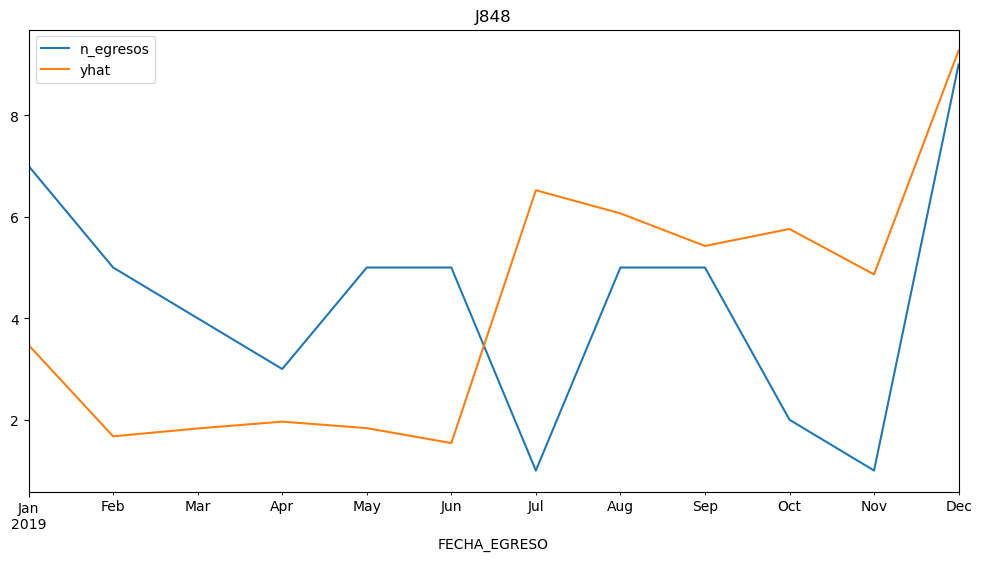

> J679
Performance on Validation Set:
  MAE: 2.3651556483759664
  MAPE: 52.81658669411108



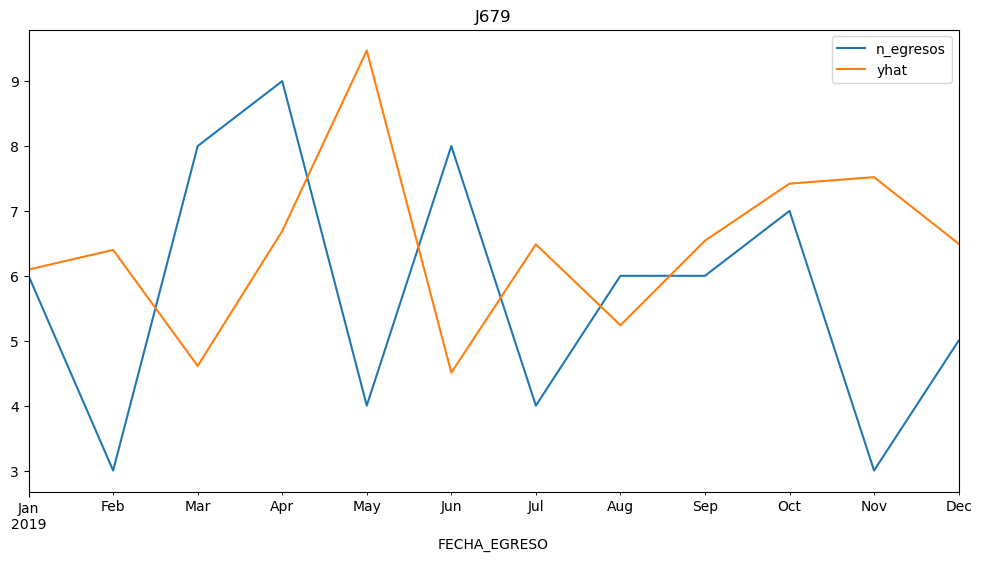

> D143
Performance on Validation Set:
  MAE: 2.2590390071341897
  MAPE: 74.06257004350654



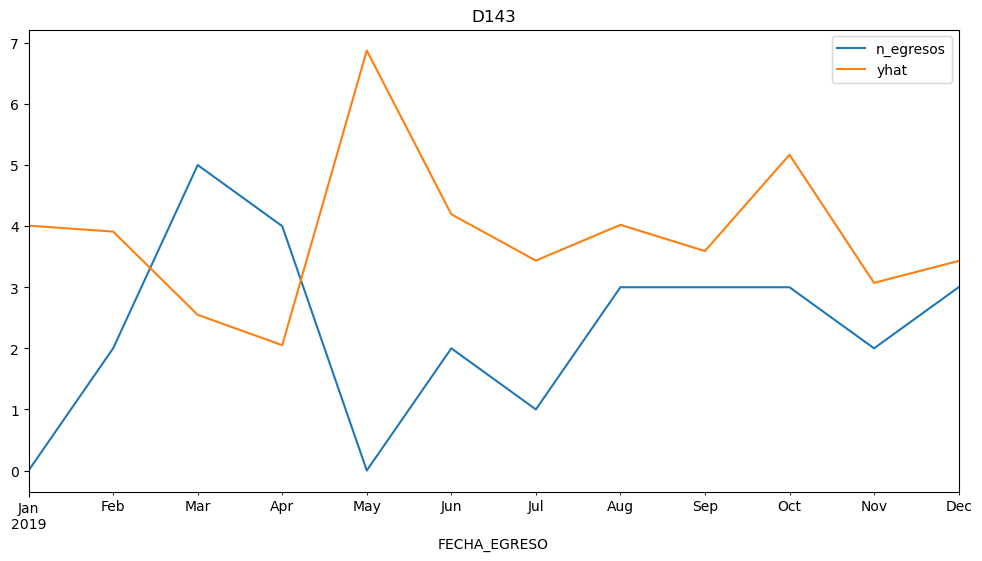

> C381
Performance on Validation Set:
  MAE: 1.0840113049094007
  MAPE: 44.064786078492766



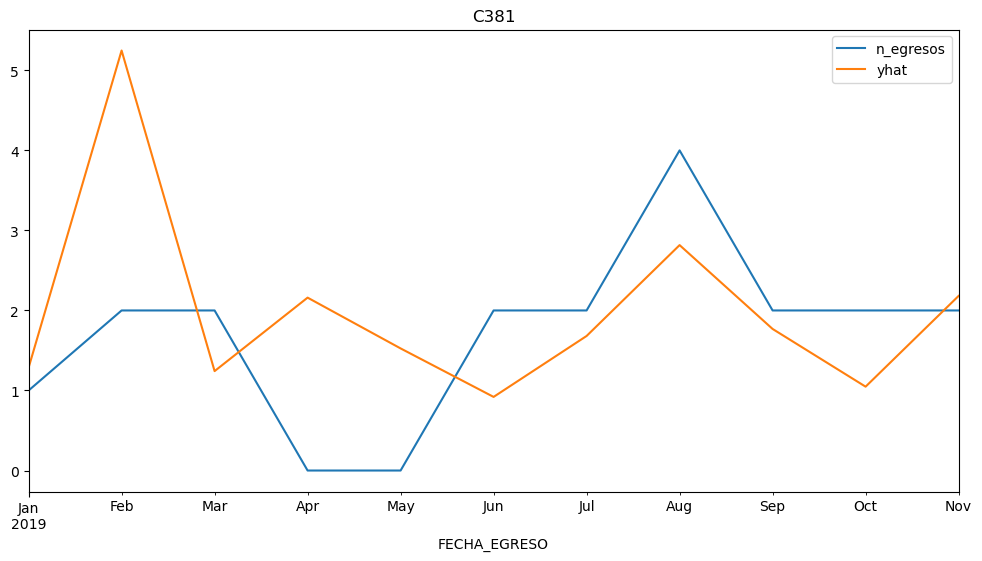

> J849
Performance on Validation Set:
  MAE: 1.7478019463933925
  MAPE: 67.36717008778406



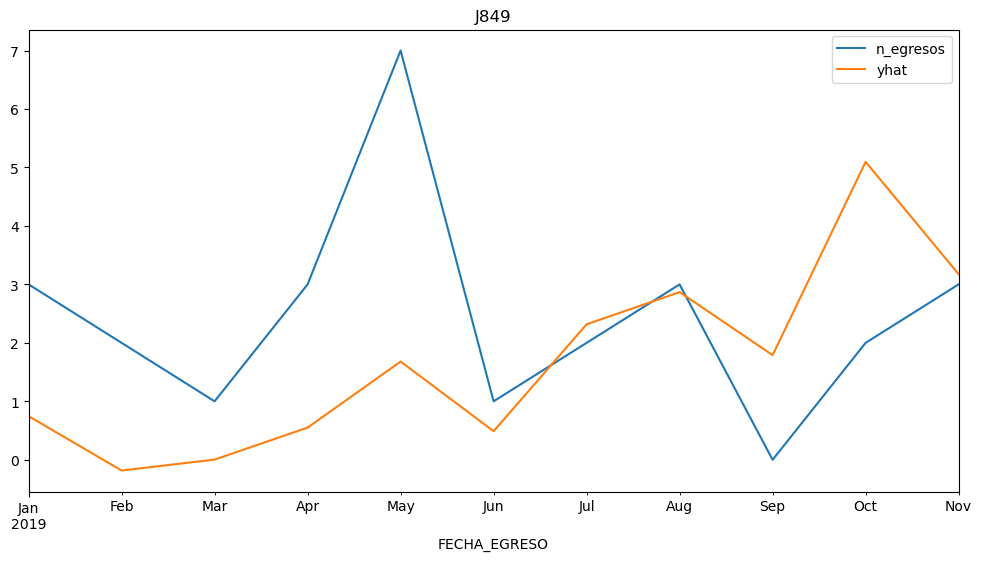

> I080
Performance on Validation Set:
  MAE: 2.087861175471648
  MAPE: 104.14133200851998



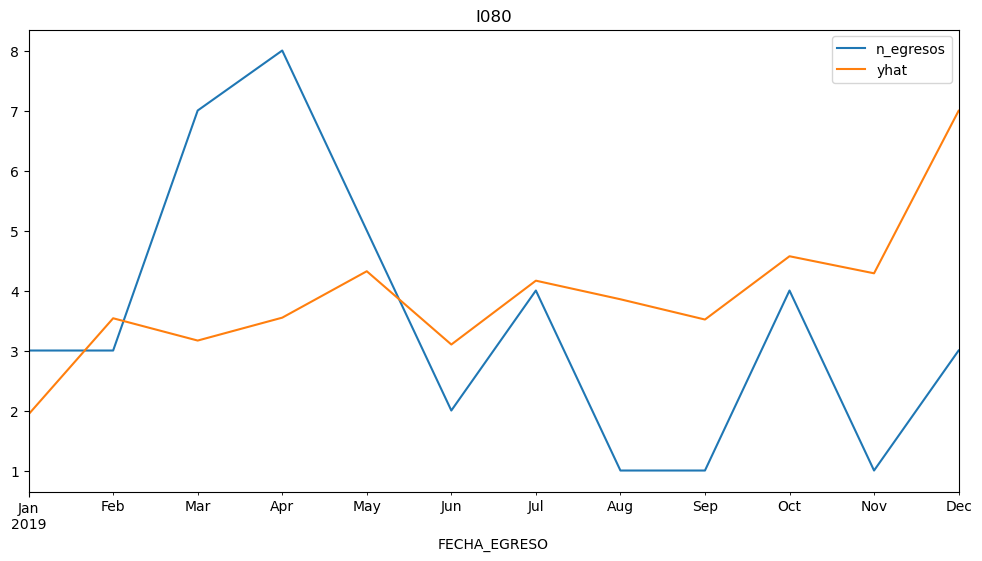

> I472
Performance on Validation Set:
  MAE: 1.0772377800347157
  MAPE: 64.26297439865387



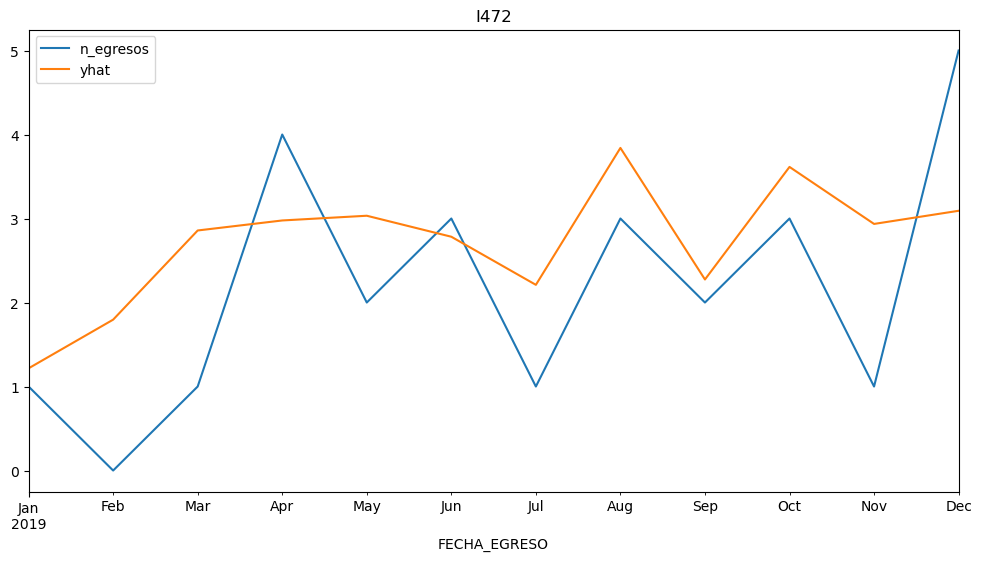

> C342
Performance on Validation Set:
  MAE: 1.4780975821933862
  MAPE: 85.92946452277482



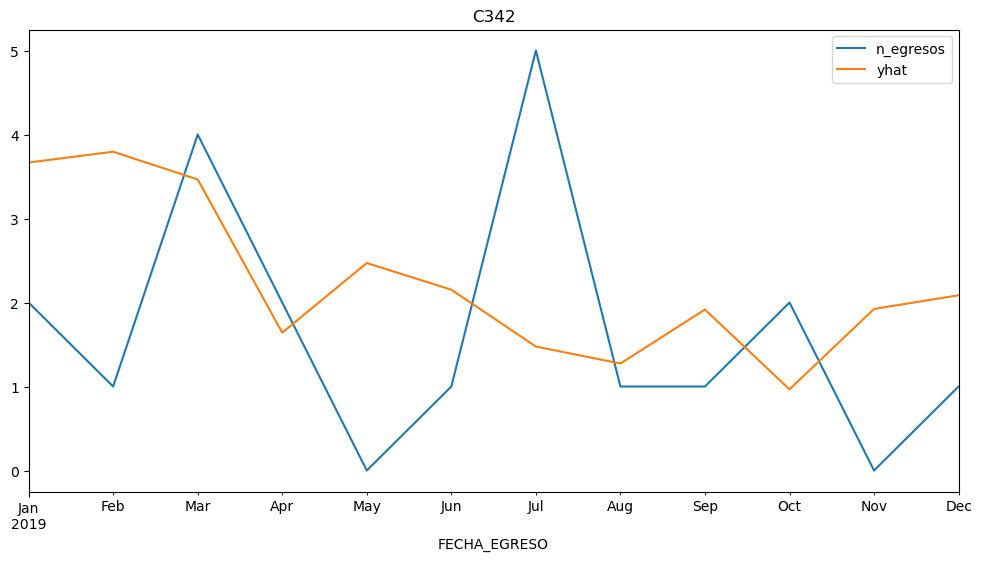

> Z450
Performance on Validation Set:
  MAE: 4.413832935124057
  MAPE: 84.4419903306802



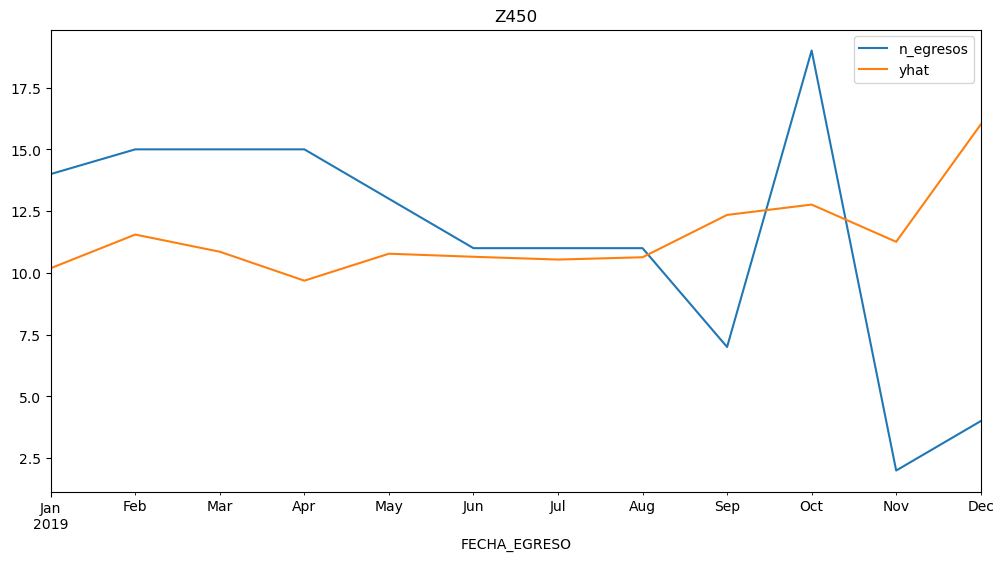

> E848
Performance on Validation Set:
  MAE: 1.185703499654718
  MAPE: 64.96297618608017



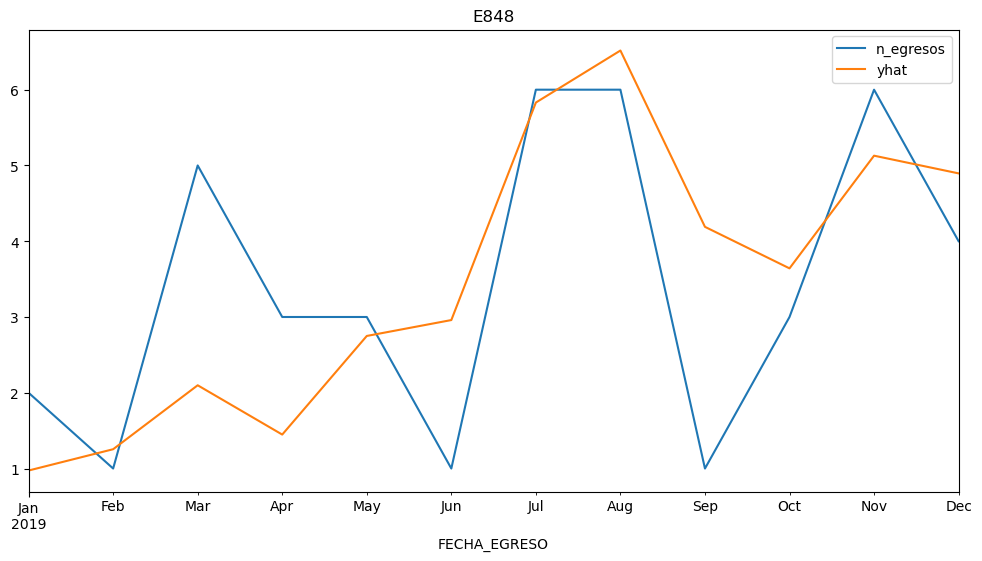

> I712
Performance on Validation Set:
  MAE: 1.128868855247755
  MAPE: 72.459825551864



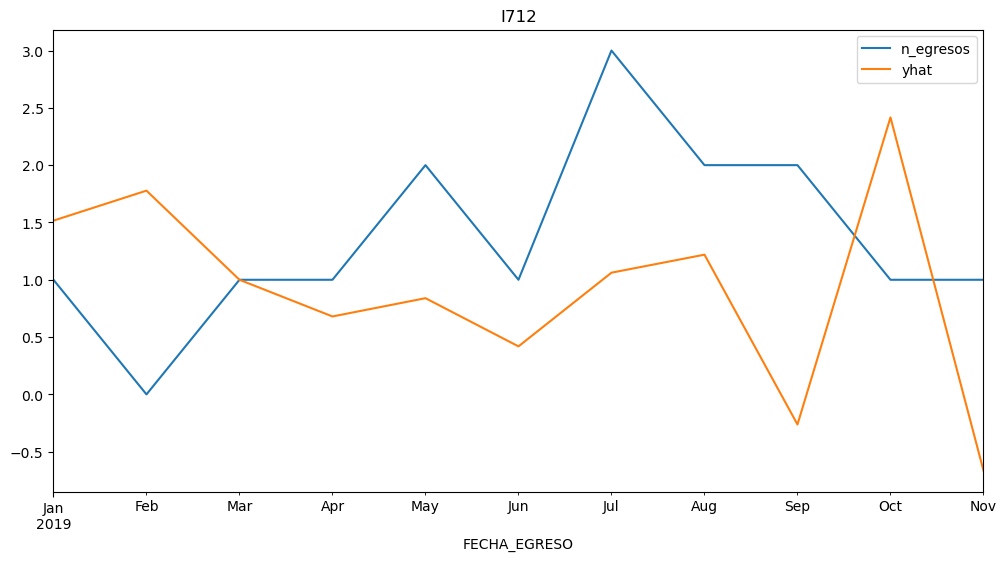

> I081
Performance on Validation Set:
  MAE: 1.6678184504623157
  MAPE: 94.0423721315042



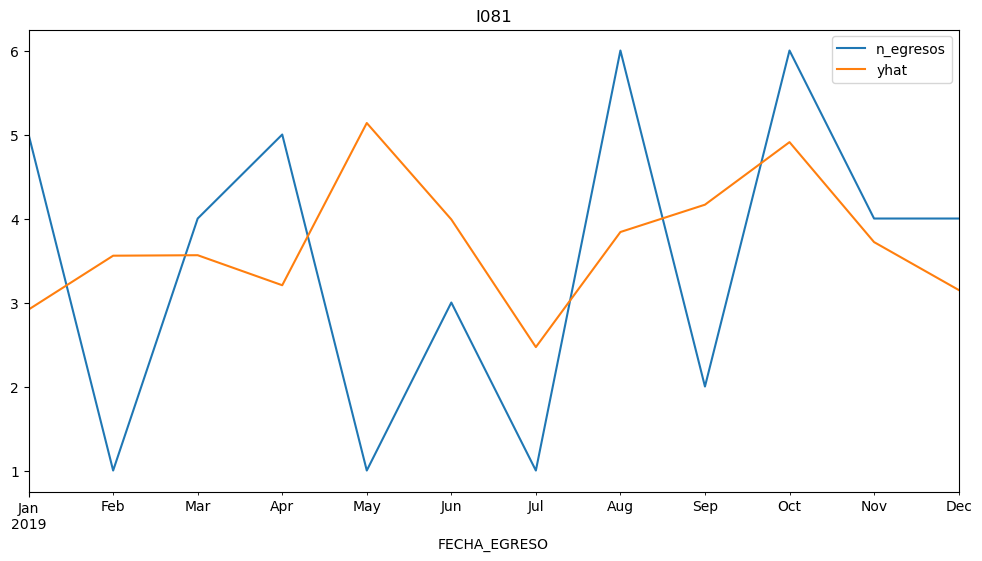

> I352
Performance on Validation Set:
  MAE: 1.6947927284984219
  MAPE: 63.64540470146457



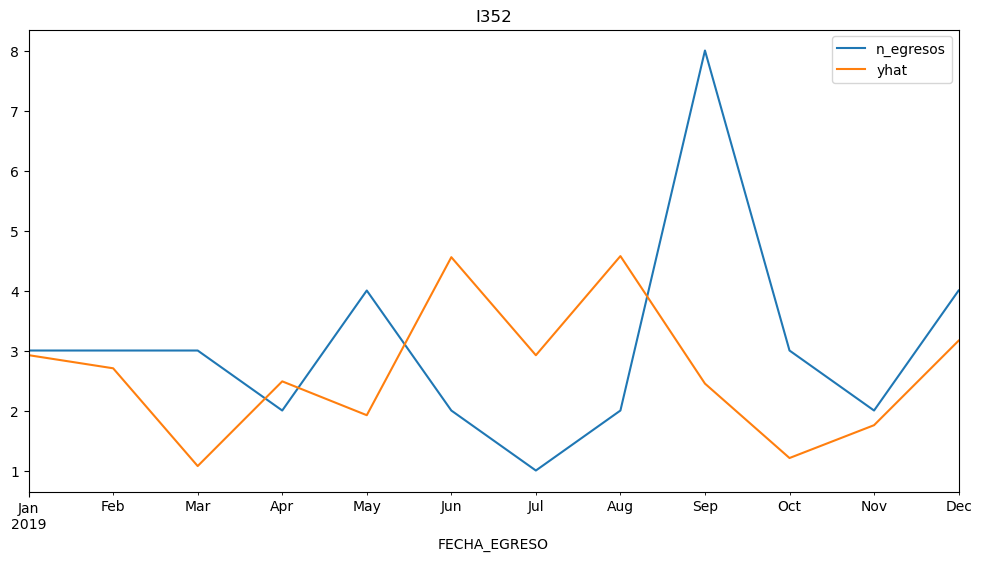

> M348
Performance on Validation Set:
  MAE: 1.6706697926210028
  MAPE: 66.67370679451582



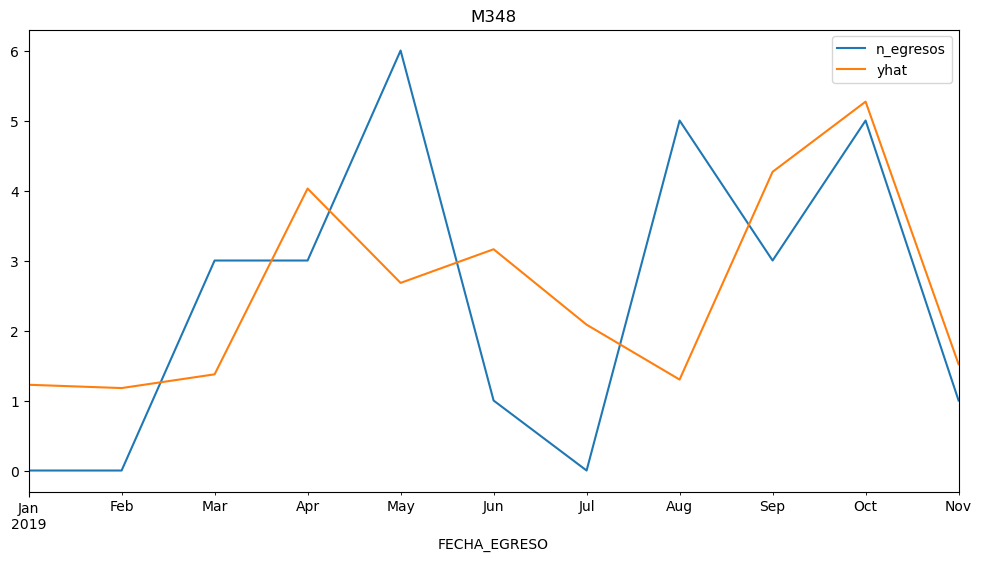

In [172]:
CORTE_VALID = "2019-01-01"
TARGET = "n_egresos"

# En este entrenamiento se obviara la busqueda en grilla de hiperparametros

resultado_modelos = {}

for diagnostico in df["DIAG1"].unique():
    print(f"> {diagnostico}")
    df_diag = df.query("DIAG1 == @diagnostico").drop(columns="DIAG1").resample("M").sum()[[TARGET]]

    # Separacion en datos de entrenamiento y validacion

    train_diag = df_diag[df_diag.index < CORTE_VALID]
    valid_diag = df_diag[df_diag.index >= CORTE_VALID]

    # Obtencion de X_train y y_train
    X_train_1_diag = DeterministicProcess(index=train_diag.index, order=1, drop=True).in_sample()
    X_train_2_diag = build_features.create_features_datetime_index(train_diag).drop(columns=TARGET)
    y_train_diag = train_diag[TARGET]

    # Obtencion de X_valid y y_valid
    ULTIMO_TREND_TRAIN = X_train_1_diag.iloc[-1, 0]
    X_valid_1_diag = (
        DeterministicProcess(index=valid_diag.index, order=1, drop=True).in_sample()
        + ULTIMO_TREND_TRAIN
    )
    X_valid_2_diag = build_features.create_features_datetime_index(valid_diag).drop(columns=TARGET)
    y_valid_diag = valid_diag[TARGET]

    #### Definir Modelos
    modelo_1 = LinearRegression(fit_intercept=True)
    modelo_2 = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)

    modelo_hibrido = train_model.ModeloHibrido(modelo_1, modelo_2, None, None, n_splits=None)

    # Entrena Modelos
    modelo_hibrido.fit(X_train_1_diag, X_train_2_diag, y_train_diag)
    
    # Reporta desempeño modelo
    modelo_hibrido.check_validation_score(X_valid_1_diag, X_valid_2_diag, y_valid_diag)
    y_valid_diag = y_valid_diag.to_frame()
    y_valid_diag["yhat"] = modelo_hibrido.predict(X_valid_1_diag, X_valid_2_diag)
    y_valid_diag.plot(title=diagnostico)
    plt.show()
    
    # Guarda resultados
    resultado_modelos[diagnostico] = modelo_hibrido

In [146]:
y_valid_diag

FECHA_EGRESO
2019-01-31    0
2019-02-28    0
2019-03-31    3
2019-04-30    3
2019-05-31    6
2019-06-30    1
2019-07-31    0
2019-08-31    5
2019-09-30    3
2019-10-31    5
2019-11-30    1
Freq: M, Name: n_egresos, dtype: int64